# Working with Picasso Localization data

This file contains the code and the corresponding description for filtering and analyzing DNA-PAINT localization data, which was obtained by using the localization program of the Picasso software.

The goal of the following code is to analyze and filter localization data, specifically that of Carbon Nano Tubes that were imaged using the DNA-PAINT method.   
The code uses the common python libraries for data analysis, i.e. NumPy, Pandas, Matplotlib, Seaborn, etc.   

Note that the Filter program of the Picasso software already contains basic methods for analysis such as displaying localization data in tabular form, creating basic histograms and filtering data by setting boundaries (i.e. max and min values).     

Additionaly, Picassos' Render program offers a convenient way for imaging the localization data via a 2D scatterplot with additional contrast representation (contrast is proportional to the photon count of a localization).   

The following is therefore supposed to serve as an extension and an example on how to work with Picassos' localization data outside of the Picasso program itself. **It is necessary to read the attached document "Using DNA-PAINT and the Picasso Software to image Carbon Nanotube Structures" first to fully understand the steps of this script!** (more information on the Picasso programs is also given in that document).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import os.path as _ospath
import time
import math
import warnings

In [2]:
warnings.filterwarnings("ignore")

The following script is divided into 4 parts.    

The first section imports the localization data, i.e. the hdf5 file, from your specified path and provides basic descriptive statistics on the data. It also visualizes the distributions of important parameters.    

The second section filters the data with respect to certain parameters.

The third section shows how it is possible to create an image from the localization data yourself without using the Render program from Picasso.

The fourth section explains how you can export the filtered data, so that an image can be created using in the Render program.   
The images from section 3 and 4 are then compared and the functionalisation density of the imaged Carbon Nano Tubes is calculated.

## 1. Importing localization data and providing basic descriptive statistics

$$ \textbf{Submit the path to your localization data (i.e. the hdf5 file created by Picassos' Localization program) into the locs_path variable.}$$   


In [3]:
locs_path = "C:/Users/mariu/Desktop/Prozessiert/Dataset_1/Whole_Grid/20211122_Nanotubes_1a_ibidi_grid50_A_K1_1nM_50p_100mW_100ms_642_01_480x480x_40k_locs.hdf5"

(Note: Running the whole script top to bottom may take around 7-10 minutes)

The following code snippet provides basic descriptional statistics:

In [4]:
# Loading localization data
locs = pd.read_hdf(locs_path, key="locs")
# Data frame size
print("The submitted data contains " + str(locs.shape[0]) + " localizations with " + str(locs.shape[1]) + " parameters each.\n")
# Camera frames
frames = locs["frame"].nunique()
print("The camera collected the data over " + str(frames) + " frames.")
# Grid size
minX = locs["x"].min()
maxX = locs["x"].max()
xRange = maxX - minX

minY = locs["y"].min()
maxY = locs["y"].max()
yRange = maxY - minY

print("The data spans over a " + str(math.ceil(xRange)) + " * " + str(math.ceil(yRange)) + " (camera-) pixel wide grid.")

# minimum net_Gradient
minNetGradient = locs["net_gradient"].min()
print("The minimum net Gradient of the data was set to: " + str(math.floor(minNetGradient)))

print("The first 5 localization entries are: ")
locs.head(5)

The submitted data contains 4765027 localizations with 11 parameters each.

The camera collected the data over 40000 frames.
The data spans over a 480 * 480 (camera-) pixel wide grid.
The minimum net Gradient of the data was set to: 2000
The first 5 localization entries are: 


frame         x           y       photons        sx        sy          bg  \
0      0  3.046658  194.760635  34737.859375  1.350956  1.813792  586.983948   
1      0  3.880987  460.974243   8449.246094  1.141945  0.997662  617.261780   
2      0  3.988986   83.086197   8498.592773  1.055434  0.971456  649.771606   
3      0  4.185726  273.507416   3455.363281  1.150861  1.074035  558.732239   
4      0  4.677554  286.840179   2430.919922  1.594277  1.098323  559.675598   

        lpx       lpy  ellipticity  net_gradient  
0  0.011924  0.017656     0.255176  43365.625000  
1  0.026649  0.021904     0.126349  17813.750000  
2  0.023970  0.021292     0.079568  18324.687500  
3  0.055275  0.049353     0.066755   6202.302246  
4  0.135360  0.070015     0.311084   4104.476562

(Note that each row represents a localization.)    
The complete table can be viewed conveniently via Picasso Filter.

Summary statistics of the point spread $\textbf{sx, sy}$ of the localizations (i.e. the width in x and y direction of the blinking event):

In [5]:
coloumnsToDescribe = locs[["sx","sy"]]
pd.options.display.float_format = '{:.2}'.format
result = coloumnsToDescribe.describe()
result.drop(index = "count", inplace = True)
print(result)

           sx       sy
mean      1.3      1.2
std      0.34     0.34
min  -1.3e+01 -1.2e+01
25%       1.1      1.1
50%       1.2      1.2
75%       1.3      1.3
max   5.3e+01  4.4e+01


Negative values make no physical scence and should therefore be omitted.

In [6]:
locs = locs[locs['sx'] >= 0]
locs = locs[locs['sy'] >= 0]

In [7]:
# Setting the plot style
sns.set_theme(style="whitegrid", palette = "pastel", context = "paper", font = "serif") 

Distributions of the photon counts and the net Gradient.     
The photon count shows the distribution of the intensity of the spots:

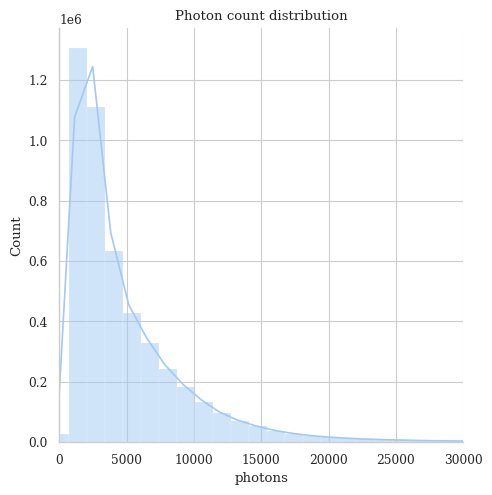

In [9]:
sns.displot(locs.photons.dropna(), kde=True, kde_kws={'bw_adjust':1.5}, rug=False, kind='hist', bins=200)

plt.title("Photon count distribution")
plt.xlim(0,30000)

plt.show()

The net Gradient was used to filter out noise (i.e. blinking events that are caused by diffusing strands. See the presentation for more information on the net Gradient):

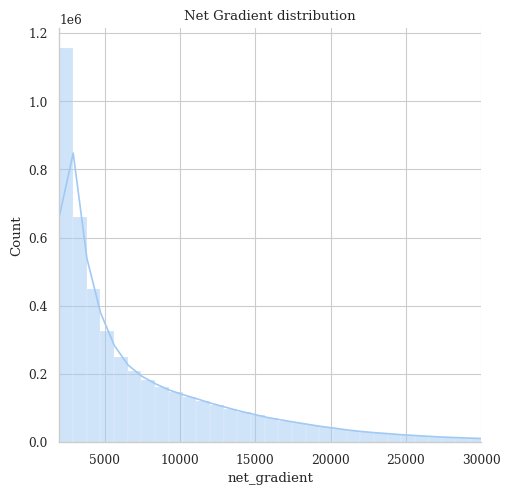

In [10]:
sns.displot(locs.net_gradient.dropna(), kde=True, kde_kws={'bw_adjust':1}, rug=False, kind='hist', bins=200)
sns.kdeplot()
plt.title("Net Gradient distribution")
plt.xlim(locs["net_gradient"].min(),30000)

plt.show()

Summary statistics of photon count and net Gradient:

In [8]:
coloumnsToDescribe = locs[["photons","net_gradient"]]
pd.options.display.float_format = '{:.2f}'.format
result = coloumnsToDescribe.describe()
result.drop(index = "count", inplace = True)
print(result)

       photons  net_gradient
mean   4888.97       7901.57
std    4542.06       7303.03
min  -76653.48       2000.00
25%    1944.88       2945.30
50%    3308.64       5024.39
75%    6328.30      10425.74
max  190212.22     183552.34


Just as with the point spread values, negative photon count values indicate biased values and should be omitted:

In [9]:
locs = locs[locs['photons'] >= 0]

Both photon count and net gradient have a skewed normal distribution while also being tightly packed around the mean (observe the 75% percentile and the 100% percentile).

## 2. Filtering the data

### Filtering out overlapping blinking events

sx and sy of the localization data refer to the point spread of a blinking event:

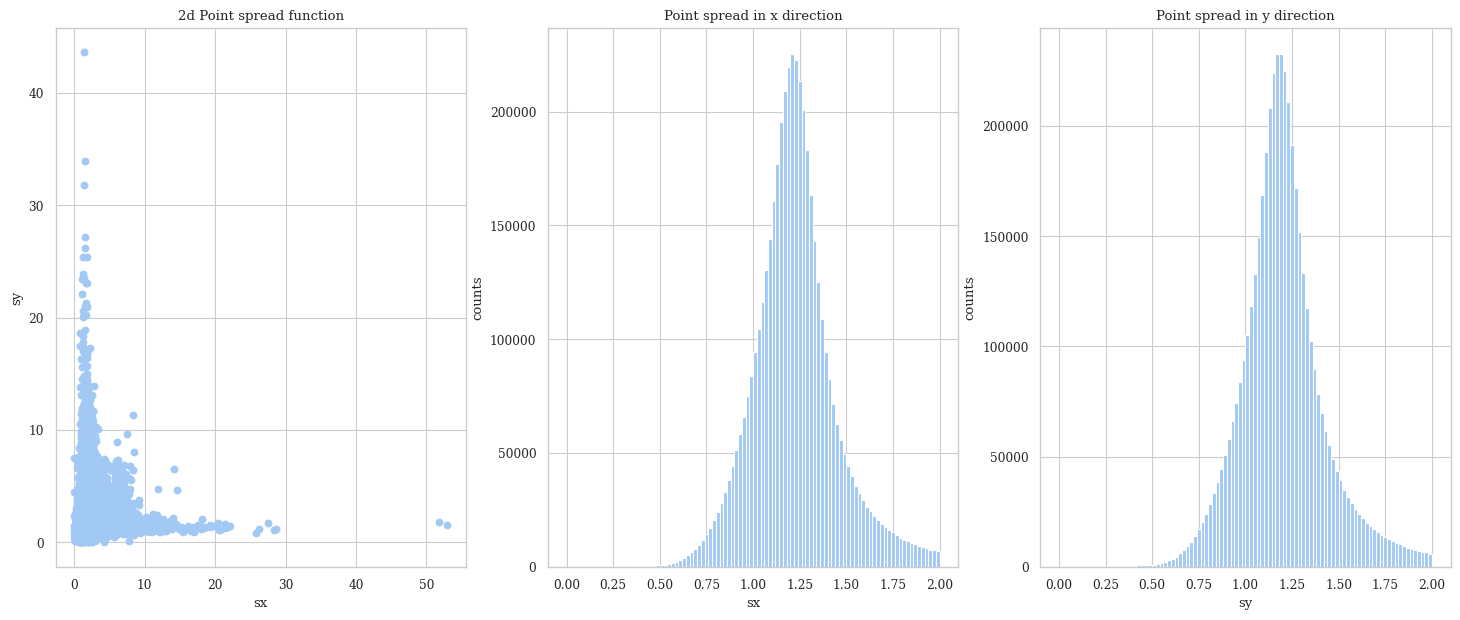

In [10]:
fig, axes = plt.subplots(nrows = 1,ncols =  3,figsize=(18, 7))
axes[0].scatter(locs.sx, locs.sy)
axes[0].set_title("2d Point spread function")
axes[0].set_xlabel("sx")
axes[0].set_ylabel("sy")
axes[1].hist(locs.sx, bins = 100, range=(0, 2))
axes[1].set_title("Point spread in x direction")
axes[1].set_xlabel("sx")
axes[1].set_ylabel("counts")
axes[2].hist(locs.sy, bins = 100, range=(0, 2))
axes[2].set_title("Point spread in y direction")
axes[2].set_xlabel("sy")
axes[2].set_ylabel("counts")
plt.show()

The point spread of a localization/blinking should obey a normal distribution.  
The mean of the point spread in each direction should be about $1.25$.    

A very high point spread indicates an overlap of a localization with other blinking events. These localizations should be omitted since the subsequent fit would be biased.   

The omission limit is set to the double of the mean (here: $2.5$), but can be adjusted with the parameter below.

Text(0, 0.5, 'sy')

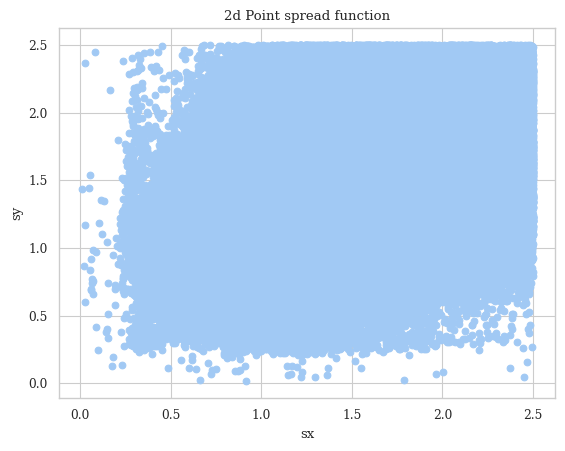

In [14]:
# Max. value for point spread
omissionLimit = 2.5

filtered_sx_sy_locs = locs[(locs["sx"] < omissionLimit) & (locs["sy"] < omissionLimit)]
######## activate the following lines if you want to see the point spread dist. after filtering ################
plt.scatter(filtered_sx_sy_locs.sx, filtered_sx_sy_locs.sy)
plt.title("2d Point spread function")
plt.xlabel("sx")
plt.ylabel("sy")

### Filtering out fits with high uncertainty

Every implemented fitting algorithm in Picasso (i.e. MLE, Least squares, Average of ROI) also provides two precision parameters of the fit (lpx, lpy), i.e. the standard deviation of the fit.

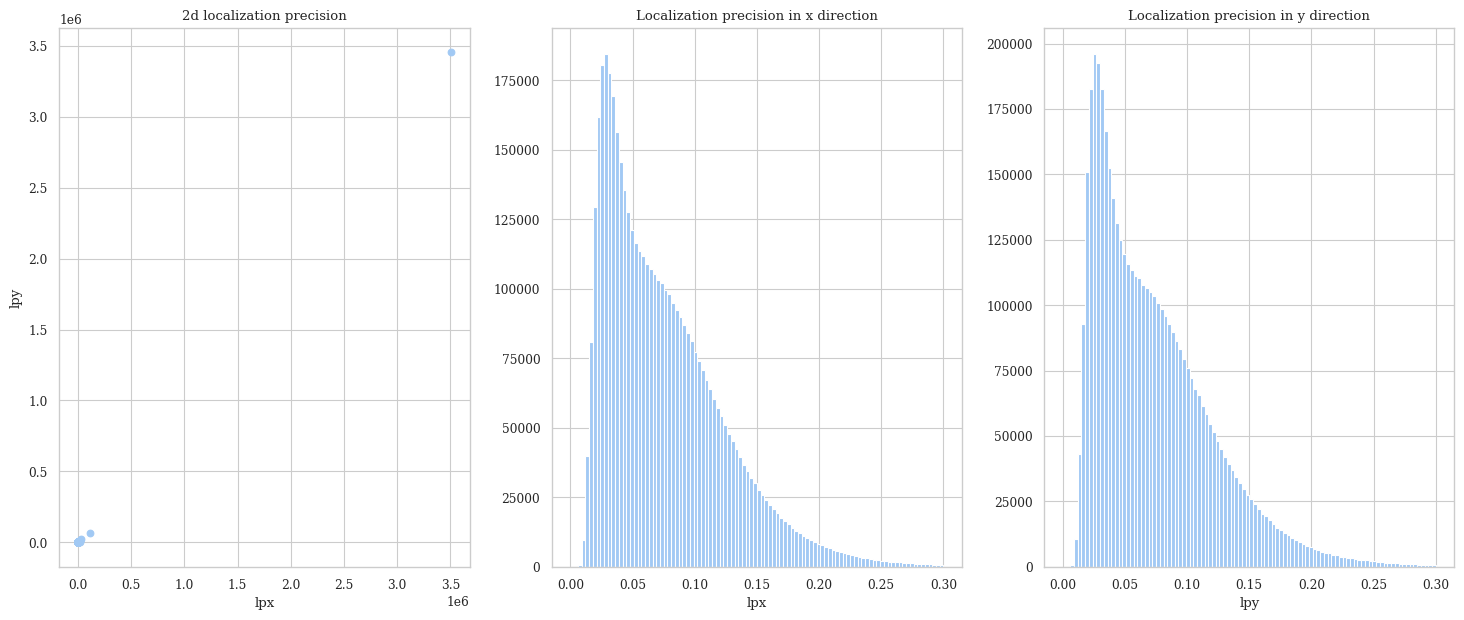

In [15]:
fig, axes = plt.subplots(nrows = 1,ncols =  3,figsize=(18, 7))
axes[0].scatter(filtered_sx_sy_locs.lpx, filtered_sx_sy_locs.lpy)
axes[0].set_title("2d localization precision")
axes[0].set_xlabel("lpx")
axes[0].set_ylabel("lpy")
axes[1].hist(filtered_sx_sy_locs.lpx, bins = 100, range=(0, 0.3))
axes[1].set_title("Localization precision in x direction")
axes[1].set_xlabel("lpx")
axes[2].hist(filtered_sx_sy_locs.lpy, bins = 100, range=(0, 0.3))
axes[2].set_title("Localization precision in y direction")
axes[2].set_xlabel("lpy")
plt.show()

The data should show a similar skewed precision distribution in both directions with a mean of about $0.03$ pixels.

(The scatterplot may show extreme outliers and is thus only useful after the filtering of uncertain fits. See below)

Again the omission border is set to two times the mean (here: $0.06$ pixels) such that blinking events with an uncertain fit are omitted. If you want to change the filtering limit adjust the parameter below.

Text(0, 0.5, 'lpy')

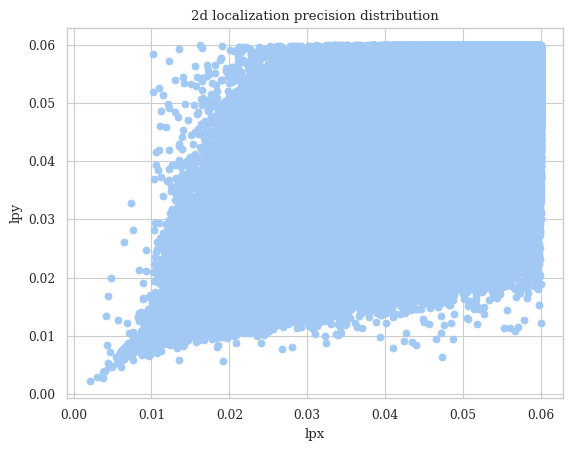

In [13]:
# Max. value for precision standard deviation
omissionLimit = 0.06

################ activate the following line if you want to see the precision distr. after filtering ################
filtered_lpx_lpy_locs = filtered_sx_sy_locs[(filtered_sx_sy_locs["lpx"] < omissionLimit) & (filtered_sx_sy_locs["lpy"] < omissionLimit)]
plt.scatter(filtered_lpx_lpy_locs.lpx, filtered_lpx_lpy_locs.lpy)
plt.title("2d localization precision distribution")
plt.xlabel("lpx")
plt.ylabel("lpy")

### Filtering out isolated spots by further analyzing Photon count and net Gradient

In [17]:
# Renaming partially filtered data
data_filtered_for_precision = filtered_lpx_lpy_locs

What is the correlation between net Gradient and Photon count? :

Elapsed time: 408.0959 seconds


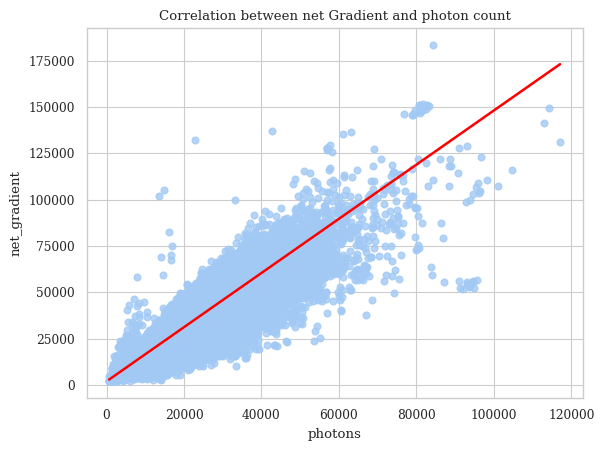

In [24]:
startTime = time.time()
sns.regplot(data= data_filtered_for_precision, x="photons", y="net_gradient", line_kws={"color": "red"})
plt.title('Correlation between net Gradient and photon count')
endTime = time.time()
elapsedTime = endTime - startTime
print(f"Elapsed time: {elapsedTime:.4f} seconds") # usually takes about 2-4 minutes depending on number of localizations

A linear trend should be observed, indicating that the net Gradient is directly proportional to the Photon count.   
There are however outliers that clearly fall out of this trend.   

The basic idea for identifying isolated spots is as follows:    
A relatively small net Gradient for a relatively hight photon count indicates places of high functionalization density, since the neighbouring space of the spot must be bright. 
Vice versa, a relatively big net Gradient for a relatively low photon count indicates spots that are rather isolated.  

Isolated spots are unlikely to be caused by a docking strand that is part of the CNT structure or they at least distort the final image of the overall structure. Highly isolated spots (i.e. spots with high net Gradient while having a low photon count) should therfore be omitted in order to create a better structural image.

To omit isolated spots the distribution of the regression residuals is calculated and a multiple of the standard deviation of the residuals is used to set the omission boundary (the boundary can be set in the first variable of the code below):

Elapsed time: 301.0687 seconds


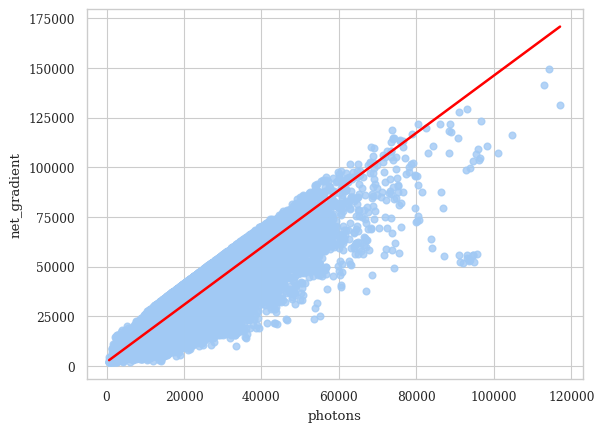

In [18]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Setting the omission boundary by the standard deviation of the residuals (which is calculated below)
multipleOfTheStandardDeviOfResiduals = 4

# Fitting the linear regression model using the OLS Regression module from the scikit library
model = LinearRegression()  # Creates an instance of the linear regression class
X = data_filtered_for_precision["photons"].values.reshape(-1, 1)
y = data_filtered_for_precision["net_gradient"].values

# Calculating the regression
model.fit(X, y) 

# Calculating the predicted values by the linear regression model
y_predicted = model.predict(X) 

# Calculating the residuals
residuals = y - y_predicted

###### To optionally bound the values on both sides of the regression line, you can activate this line! ######
#residuals = np.abs(residuals) 

# Adding the residuals column to the DataFrame
data_filtered_for_precision['residuals'] = residuals

# Setting the omission boundary as multiple standard deviations of the residuals
omissionBoundary = multipleOfTheStandardDeviOfResiduals * np.std(residuals)

# Filtering the data to exclude outliers
data_filtered_final = data_filtered_for_precision[data_filtered_for_precision['residuals'] < omissionBoundary]

# Plotting the filtered data
startTime = time.time()
sns.regplot(data= data_filtered_final, x="photons", y="net_gradient", line_kws={"color": "red"})
endTime = time.time()
elapsedTime = endTime - startTime
print(f"Elapsed time: {elapsedTime:.4f} seconds") # takes about 2-4 minutes depending on number of localizations

# An extra variable to use for examining localization density later on (can be ignored for now)
data_filtered_final_for_density_analysis = data_filtered_final

Note that for the final rendered image high photon counts should be ignored when setting the contrast range, such that very bright spots don't distort the contrast of the final image!

Recap of the photon count statistics:

In [19]:
coloumnsToDescribe = data_filtered_final[["photons"]]
pd.options.display.float_format = '{:.2f}'.format
result = coloumnsToDescribe.describe(percentiles = [0.95, 0.96, 0.97, 0.98, 0.99, 0.995, 1])
result.drop(index = "count", inplace = True)
print(result)

        photons
mean    8317.64
std     4970.65
min      670.10
50%     6985.18
95%    17601.46
96%    18782.23
97%    20398.02
98%    22770.09
99%    26937.35
99.5%  31345.96
100%  117071.57
max   117071.57


As 99% of all photon counts are under 28000, one should set the contrast max. in the Render program accordingly!

Filtering process overview:

In [20]:
print('{} localizations have been filtered out, which is {}% of the original data'.format(len(locs)-len(data_filtered_final), ((len(locs)-len(data_filtered_final))/len(locs))*100))
print('Localizations before filtering: {}, Localizations after filtering: {}.'.format(len(locs),len(data_filtered_final)))

2801163 localizations have been filtered out, which is 58.81090884125737% of the original data
Localizations before filtering: 4762999, Localizations after filtering: 1961836.


## 3. Creating the structural image from the filtered data

Does the postion data allow for reaccuring localizations?

In [21]:
# Counting localisations in the filtered data
print("The filtered localization data has " + str(data_filtered_final.shape[0]) + " localizations.")

# Counting unique localisations in the filtered data
location_counts = data_filtered_final.groupby(['x', 'y']).size().reset_index(name='count')
print("Of these localizations " + str(len(location_counts["count"])) + " are unique.")

The filtered localization data has 1961836 localizations.
Of these localizations 1961834 are unique.


The localization data contains almost exlusively unique localizations, since the precision of each localization goes to the 7th significant digit.     
However, since the fit precision on average is $0.03$ pixels, it makes sense to conjoin localizations that only differ at the second significant digit (or higher) to create a better structural image (In Picasso's Render, which displays all unique localizations, one can set a blur to get a similar effect).

In [22]:
data_filtered_final['x_truncated'] = data_filtered_final['x'].apply(lambda x: round(x, 1))
data_filtered_final['y_truncated'] = data_filtered_final['y'].apply(lambda y: round(y, 1))

# Group by the truncated values and count occurrences
grouped_locations = data_filtered_final.groupby(['x_truncated', 'y_truncated']).size().reset_index(name='count')
print(grouped_locations)

        x_truncated  y_truncated  count
0              1.70       162.70      1
1              1.70       210.30      1
2              1.80       149.70      1
3              1.80       205.90      1
4              1.80       315.80      1
...             ...          ...    ...
970379       476.00       116.00      1
970380       476.00       143.80      1
970381       476.00       253.40      1
970382       476.00       397.40      1
970383       476.10       253.40      1

[970384 rows x 3 columns]


Creating the final image of the overal structure using the grouped locations:

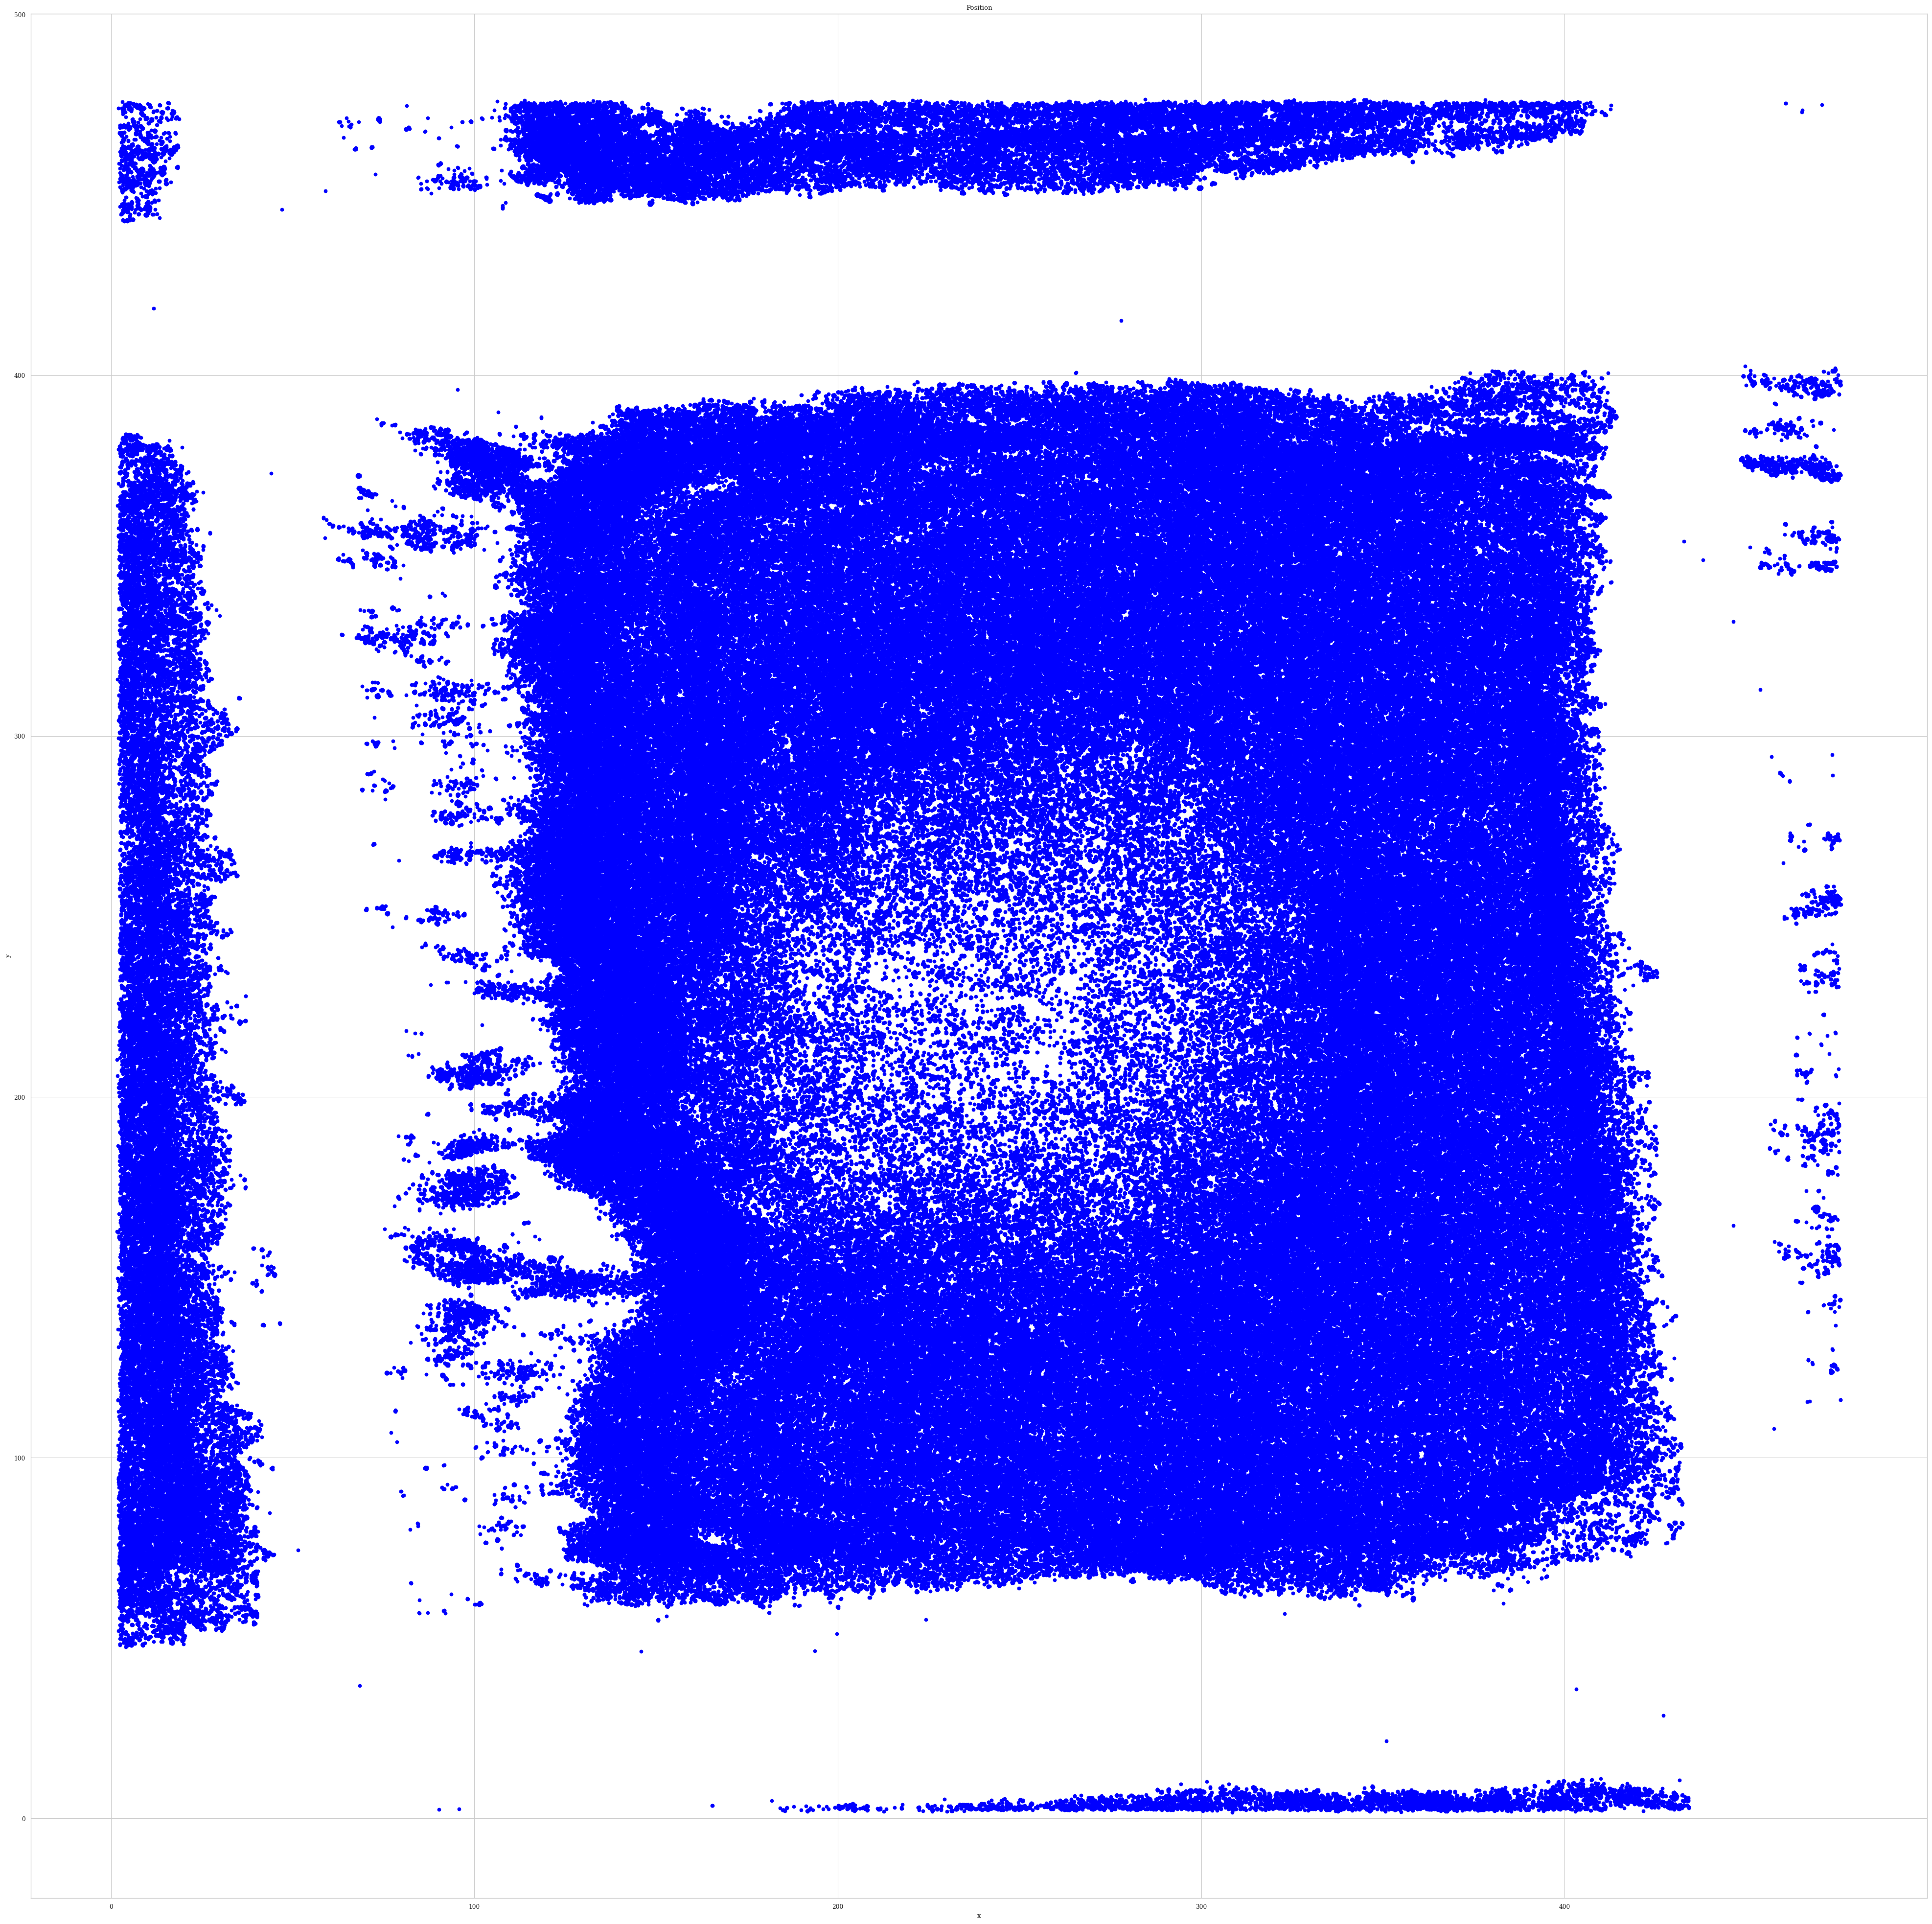

In [23]:
plt.figure(figsize=(50, 50))

x_positions = grouped_locations["x_truncated"]
y_positions = grouped_locations["y_truncated"]

# Create the scatterplot
plt.scatter(x_positions, y_positions, label='Final_image', color='blue')

# Adding labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Position')

# Show the plot
plt.savefig('final_image.png', format='png')

Zooming into a region of interest (ROI):

Specify the ROI by stating the x- and y-range of the grid:

In [37]:
# Specify the region you want to zoom in
# e.g. (200-300, 100-200)
x_min = 200
x_max = 280
y_min = 100
y_max = 180

final_image_zoomed_into_ROI_x300-350_y80-120.png


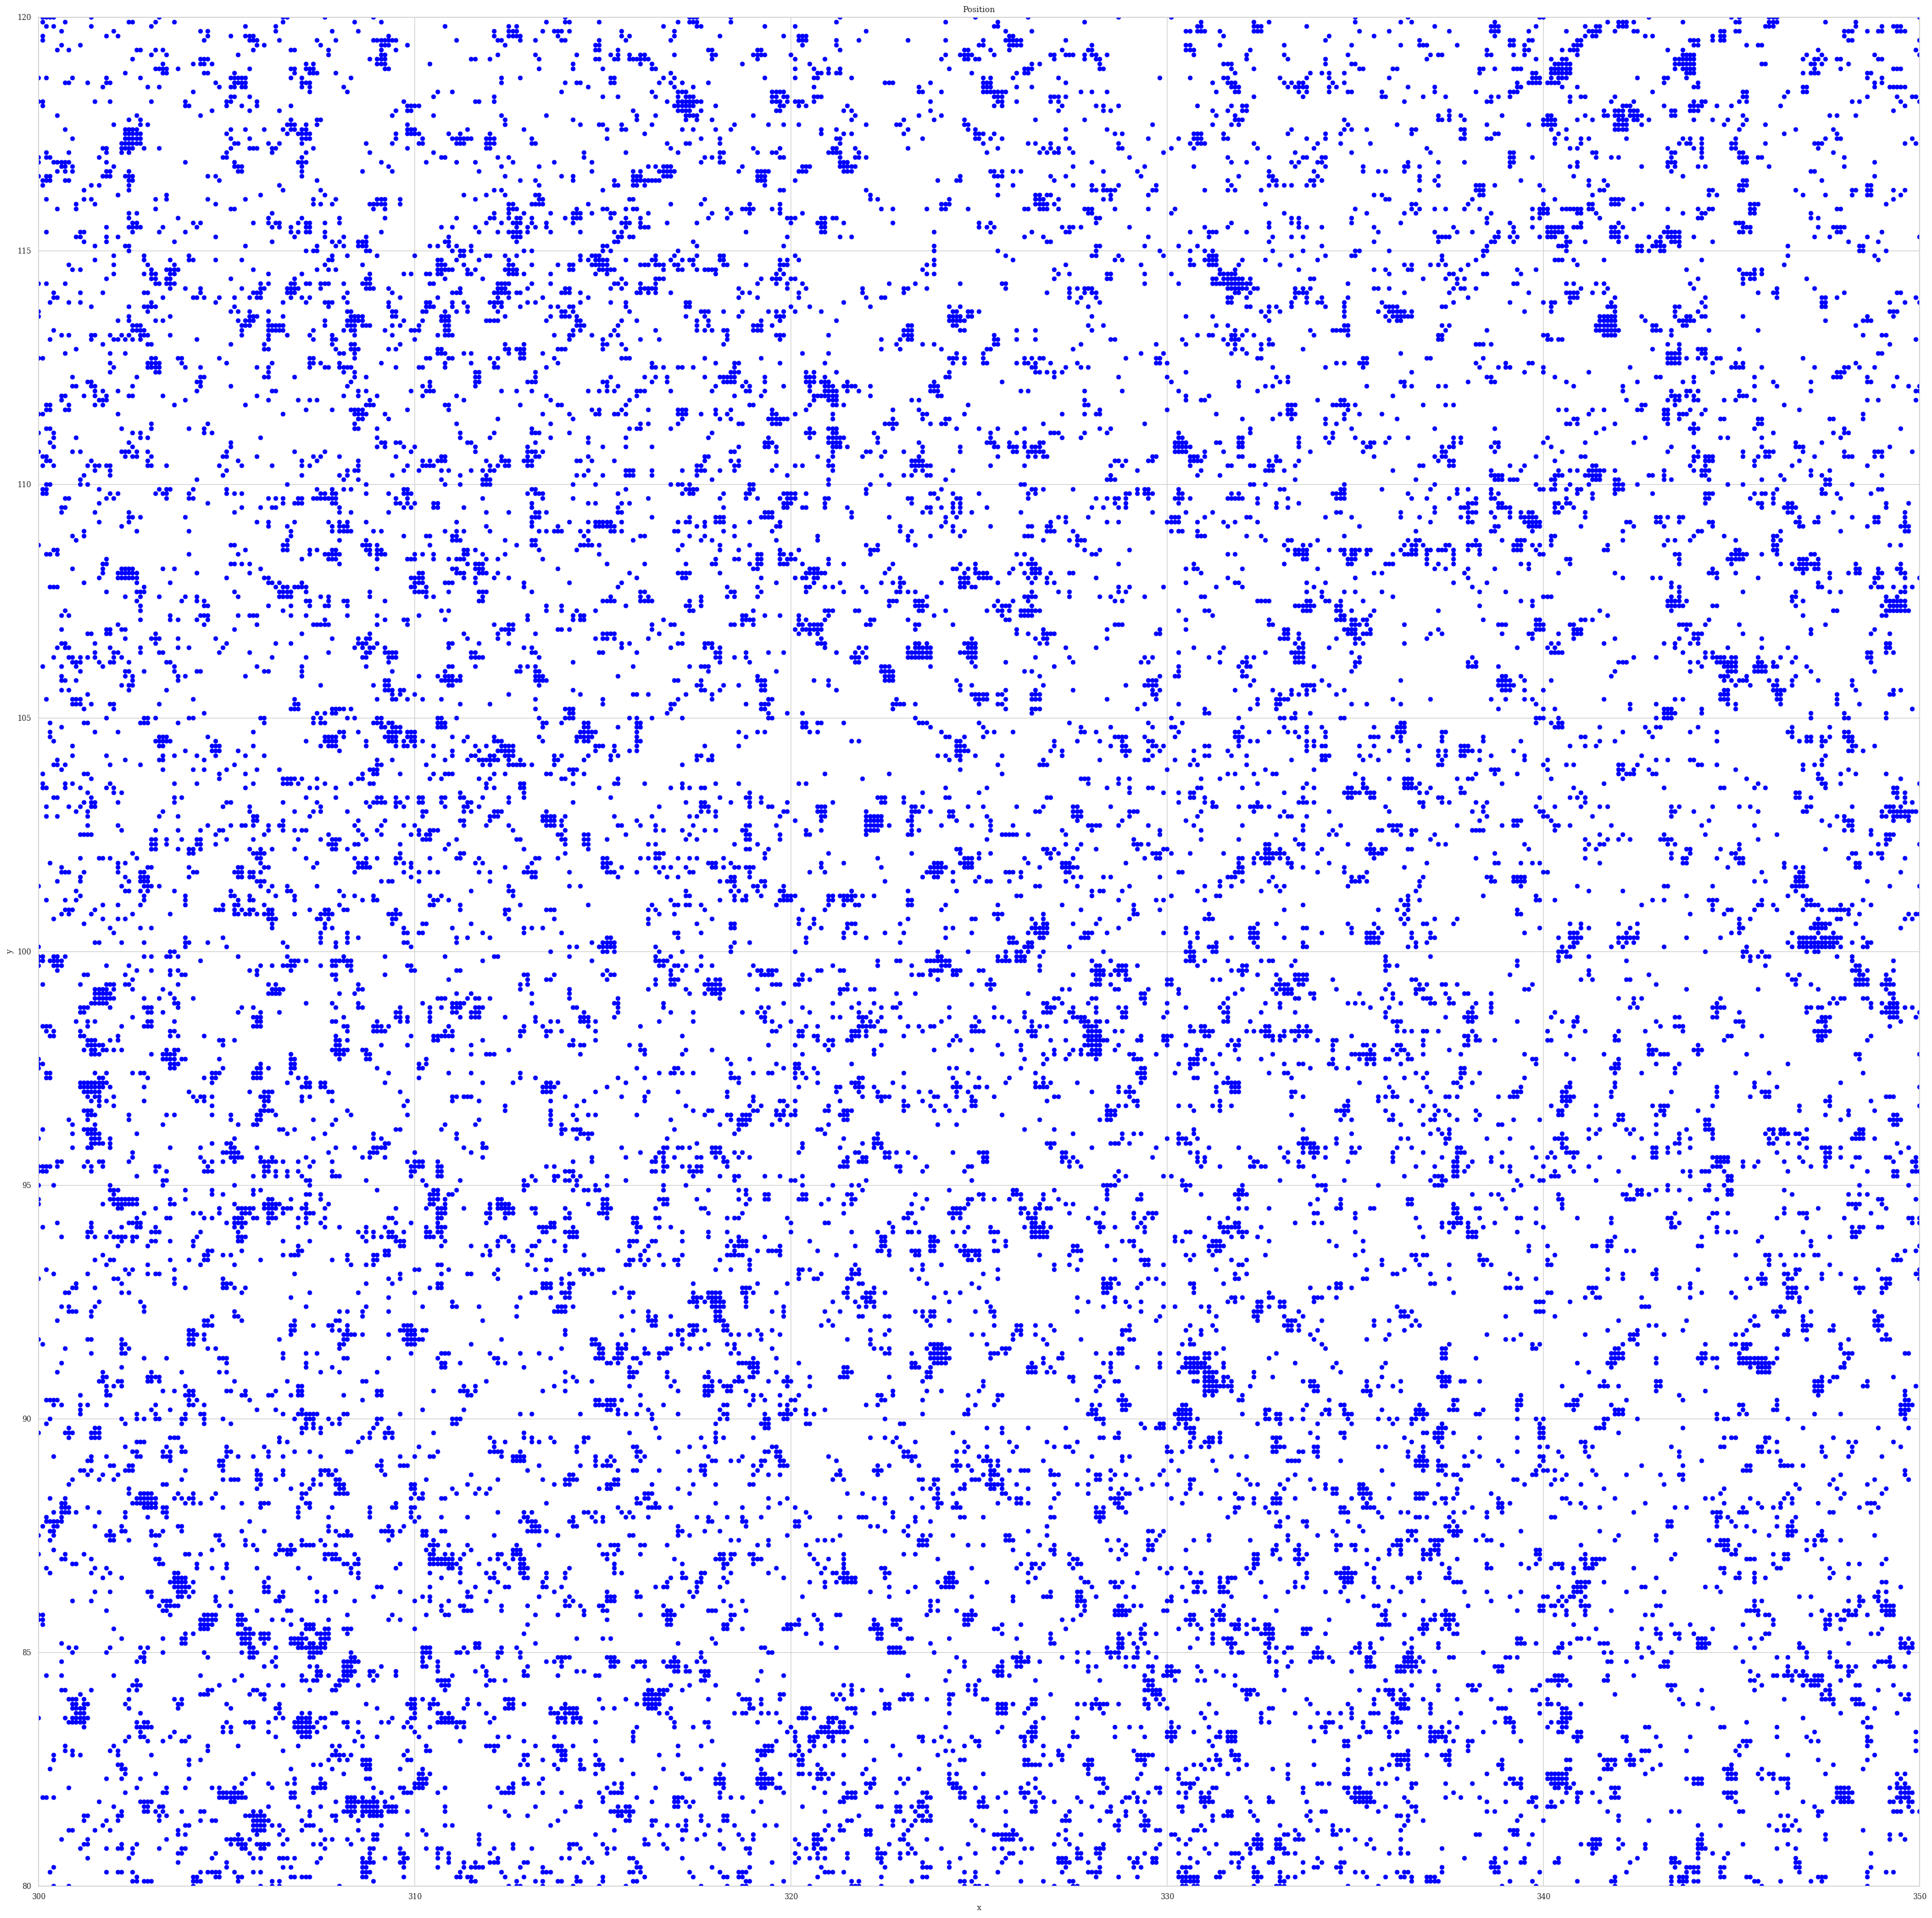

In [47]:
plt.figure(figsize=(40, 40))

x_positions = grouped_locations["x_truncated"]
y_positions = grouped_locations["y_truncated"]

# Create the scatterplot
plt.scatter(x_positions, y_positions, label='Final_image', color='blue')

# The ROI
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Adding labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Position')

# Show the plot
saving_file = 'final_image_zoomed_into_ROI_x{}_y{}.png'.format(str(x_min) + "-" + str(x_max),str(y_min) + "-" + str(y_max))
print(saving_file)
plt.savefig(saving_file, format='png') # Saving the image into a png file

(Idea for better resolution of the tubular structure: Connecting dots with their nearest neighbors?)

# 4. Rendering the final image via Picassos' Render program

Alternatively, for the final image creation the above filtered localization data can also be exported into the Picasso Render program.     
The program then creates the final image by creating a 2d heat map of localizations where the photon count determines the contrast.   

Transforming the filtered data (from its' data frame format) back into a format that the Render program can process is a bit tricky tho.

To load the data into the Render program, the picasso python library must be used.    

To use the picasso library you need an Anaconda environment which uses a python 3.10 version. You then need to install the *picassosr* package in that environment to use the picasso functions. Unfortunately, since the *picassosr* package is dependent on older versions of numpy, matplotlib, etc. other packages (such as seaborn) may cause compatibility issues (as i had to experience myself....).    
For that reason one should use a different environment (i.e. the standard environment with all up to date packages) to analyze and filter the localization data and then load the filtered data in form of a record array into the notebook "WorkingWithThePicassoLibrary" which contains the *picassosr* package.
For more details on this see the attached document or the other notebook.

The following code transforms the data frame of the localization data into a numpy *record array* since the picasso library takes the data as a record array for input.

First the added columns for the linear regression ("residuals") and the grouping ("x_truncated" and "y_truncated") that were added during the filtering steps must be removed again.

In [39]:
data_filtered_final.head(5)

frame    x      y  photons   sx   sy     bg  lpx  lpy  ellipticity  \
0      0 3.05 194.76 34737.86 1.35 1.81 586.98 0.01 0.02         0.26   
1      0 3.88 460.97  8449.25 1.14 1.00 617.26 0.03 0.02         0.13   
2      0 3.99  83.09  8498.59 1.06 0.97 649.77 0.02 0.02         0.08   
3      0 4.19 273.51  3455.36 1.15 1.07 558.73 0.06 0.05         0.07   
6      0 4.98 243.56  4163.79 1.23 1.17 543.75 0.05 0.05         0.05   

   net_gradient  residuals  x_truncated  y_truncated  
0      43365.62   -9357.43         3.00       194.80  
1      17813.75    3574.61         3.90       461.00  
2      18324.69    4013.31         4.00        83.10  
3       6202.30    -726.29         4.20       273.50  
6       7276.03    -689.63         5.00       243.60

In [40]:
data_filtered_final = data_filtered_final.drop(['residuals', 'x_truncated', 'y_truncated'], axis=1)

In [41]:
data_filtered_final.head(5)

frame    x      y  photons   sx   sy     bg  lpx  lpy  ellipticity  \
0      0 3.05 194.76 34737.86 1.35 1.81 586.98 0.01 0.02         0.26   
1      0 3.88 460.97  8449.25 1.14 1.00 617.26 0.03 0.02         0.13   
2      0 3.99  83.09  8498.59 1.06 0.97 649.77 0.02 0.02         0.08   
3      0 4.19 273.51  3455.36 1.15 1.07 558.73 0.06 0.05         0.07   
6      0 4.98 243.56  4163.79 1.23 1.17 543.75 0.05 0.05         0.05   

   net_gradient  
0      43365.62  
1      17813.75  
2      18324.69  
3       6202.30  
6       7276.03

Converting the format of the filtered data:

In [42]:
#Convert DataFrame to structured array
data_filtered_structured = data_filtered_final.to_records(index=False, column_dtypes = np.float32)

#Convert structured array to recarray
data_filtered_recarray = data_filtered_structured.view(type = np.recarray)

print(data_filtered_structured)

[(    0.,   3.0466576, 194.76064 , 34737.86  , 1.3509557 , 1.8137915 , 586.98395, 0.01192443, 0.01765593, 0.25517586, 43365.625 )
 (    0.,   3.880987 , 460.97424 ,  8449.246 , 1.1419454 , 0.99766207, 617.2618 , 0.0266493 , 0.02190428, 0.12634869, 17813.75  )
 (    0.,   3.9889855,  83.0862  ,  8498.593 , 1.0554341 , 0.9714558 , 649.7716 , 0.02397005, 0.02129204, 0.07956754, 18324.688 )
 ...
 (39999., 368.58484  , 118.868935,  3184.1975, 0.94026583, 0.9487666 , 567.6519 , 0.04309366, 0.04370482, 0.0089598 ,  6576.722 )
 (39999., 395.49316  , 207.34773 ,  4038.3264, 1.2609538 , 1.1459314 , 567.7904 , 0.05645171, 0.04817941, 0.09121858,  7221.69  )
 (39999., 468.85748  , 196.07391 ,  3794.5269, 1.2633505 , 1.1806291 , 546.35504, 0.05896183, 0.05266094, 0.06547775,  6564.4985)]


The following recarray (in form of a csv file) can now be importet in the other notebook:

In [43]:
# Saving the recarray as a csv file
np.savetxt('data_filtered_recarray.csv', data_filtered_structured, delimiter=',', fmt=['%d', '%.8f', '%.8f','%.8f','%.8f','%.8f','%.8f','%.8f','%.8f','%.8f','%.8f'])

The following images are from Picassos' Render program. They show the impact of the filtering process to the final image. Notice the additional contrast setting regarding the photon count.

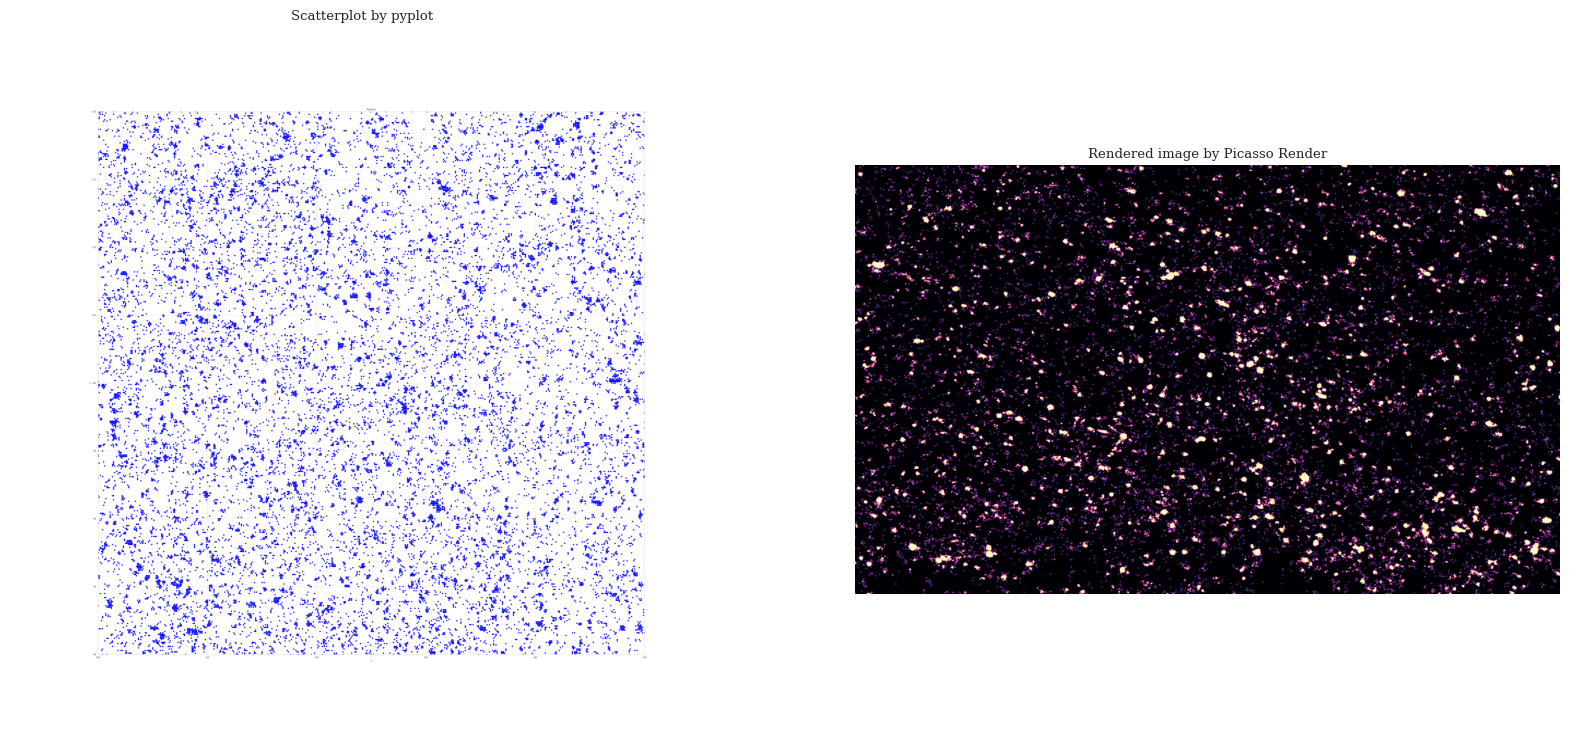

In [48]:
import matplotlib.image as mpimg
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
img1 = mpimg.imread(saving_file) # The scatterplot image
img2 = mpimg.imread("picasso_image.png") # The image from the render program
ax1.imshow(img1)
ax1.axis('off')
ax1.set_title("Scatterplot by pyplot")
ax2.imshow(img2)
ax2.axis('off')
ax2.set_title("Rendered image by Picasso Render")
plt.show()

## Functionalisation density: Average distance between Localizations

To get an impression on the functionalization density (i.e. the spacial distance of docking strands) we calculate the average spacial distance of localizations. Note that we use the unconjoined data (conjoining the data was done to increase image quality).

In [49]:
from scipy.spatial import KDTree

#Create a KDTree from the coordinates
coords = data_filtered_final_for_density_analysis[['x', 'y']].values
tree = KDTree(coords)

#Find the nearest neighbor for each localization (excluding the localization itself)
distances, _ = tree.query(coords, k=2)  # k=2 to include the localization itself and its nearest neighbor

#Extract the distances to the nearest neighbor (ignoring the first column which is the distance to itself)
nearest_distances = distances[:, 1]

#Calculate the average free radius
average_free_distance = np.mean(nearest_distances)

print("The average distance of a localization to the next localization is " + str(average_free_distance) + " pixels.")


The average distance of a localization to the next localization is 0.0635421873928445 pixels.
